In [1]:
#!conda activate jupyterlab-copilot
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
#!pip install netCDF4
from netCDF4 import Dataset as NetCDFFile
import random
import timeit
import pickle
from scipy import stats
import xarray as xr
import pandas as pd
import statistics
from scipy import interpolate
import os
import pytz, datetime
import multiprocessing as mp
import geopandas
#!pip install descartes
import descartes
from datetime import date

from datetime import datetime

In [2]:
import pickle
# drive_path = '/Users/kaichiht/Library/CloudStorage/GoogleDrive-kuiper2000@gmail.com/My Drive/'
# # Load the pkl file
# with open(drive_path+'website-hugo/chaos_and_predictability/week9/Predictable_component_analysis/PNA_region.pkl', 'rb') as file:
#     data = pickle.load(file)
with open('PNA_region.pkl', 'rb') as file:
    data = pickle.load(file)

print(data['PC dimension'])
print(data['EOF dimension'])

PC  = data['PC']
EOF = data['EOF']
lat = data['lat']
lon = data['lon']

10 ensembles, 20 years, 12 months, 8 initialization (for each month), 47 lead time, 10 modes
10 modes, 20<lat<80, 100<lon<300


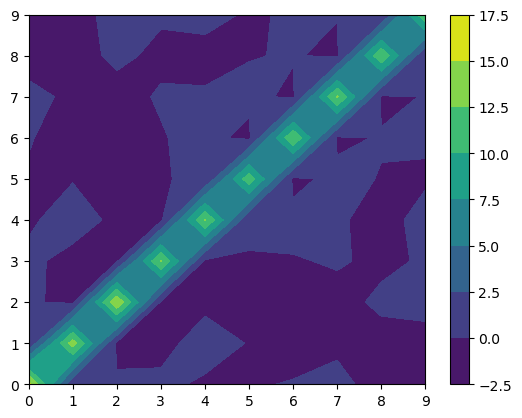

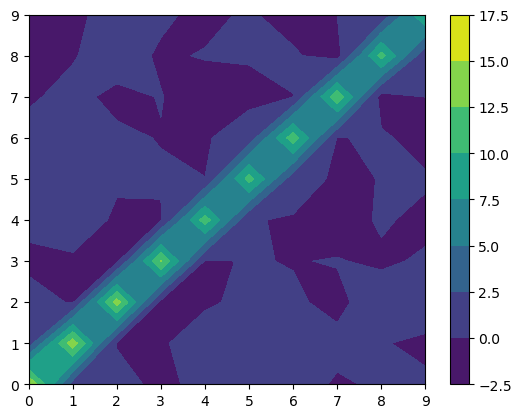

In [3]:
# PC has dimension of ens, year, month, lead, PC modes
# using lag 30-47 to define climatology 
# month            = [0,1,2,3,4,5,6,7,8,9,10,11]
mode             = 10
month            = [0,1,10,11]
PC_winter        = PC[:,:,month,:,:]
dim_PC           = np.shape(PC[:,:,month,:,:])
sigma            = np.zeros((47,mode,mode))

for i in range(dim_PC[4]):
    count = 0
    for year_idx in range(dim_PC[1]):
        for month_idx in range(dim_PC[2]):
            for init_inx in range(dim_PC[3]):
                tmp              = np.reshape(PC_winter[:,year_idx,month_idx,init_inx,i,:]-np.mean(PC_winter[:,year_idx,month_idx,init_inx,i,:], axis=0,keepdims=True),[dim_PC[0],mode])
                sigma[i,:,:]     = (tmp.T.dot(tmp)+sigma[i,:,:]*count)/(count+1)
                count            = count+1
sigma_inf = sigma[42:47,:,:].mean(axis=0)
plt.figure()
cs=plt.contourf(sigma[42:47,:,:].mean(axis=0))
plt.colorbar(cs)

cov_diff     = np.zeros((mode,mode))
for i in range(dim_PC[4]):
    cov_diff = ((sigma_inf-sigma[i,:,:]).dot(np.linalg.inv(sigma_inf))+cov_diff)
plt.figure()
cs=plt.contourf(cov_diff)
plt.colorbar(cs)

## Find spatial structure of each APTM

In [4]:
# calculate 
eigenvalues, eigenvectors = np.linalg.eig(cov_diff)
idx                       = eigenvalues.argsort()[::-1]   
eigenvalues               = eigenvalues[idx]
eigenvectors              = eigenvectors[:,idx] 
eigenvalues*2

array([34.44903878, 29.99518254, 25.8897357 , 25.23738306, 24.80906639,
       24.35043355, 21.04292533, 20.85989344, 19.80615066, 18.33728735])

## Find time-series of each APTM

In [5]:
# APTM_time_series has dimension of ens, year, month [Oct,Nov,Dec,Jan], day[8 days/month], lead, modes 
from matplotlib import colors
month                    = [0,1,10,11]
APTM_time_series         = np.reshape(PC[:,:,month,:,:],[dim_PC[0]*dim_PC[1]*dim_PC[2]*dim_PC[3]*dim_PC[4],mode]).dot(eigenvectors)
APTM_time_series         = np.reshape(APTM_time_series,[dim_PC[0],dim_PC[1],dim_PC[2],dim_PC[3],dim_PC[4],mode])
APTM_clim                = np.reshape(APTM_time_series[:,:,:,:,40:48,:],[10*20*4*8,7,mode])

(10, 20, 4, 8, 47, 10)


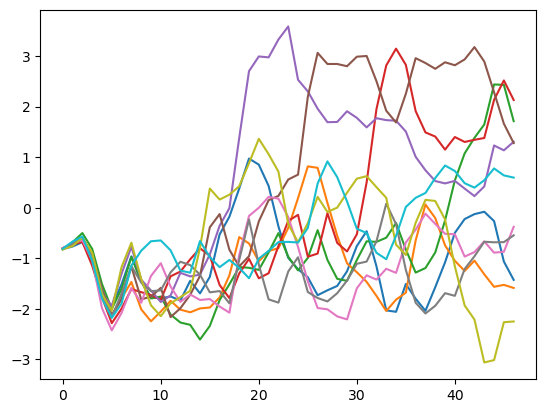

In [12]:
print(APTM_time_series.shape)
plt.figure()
plt.plot(APTM_time_series[:,0,0,0,:,0].T)


## Find Jacobian 

In [106]:
# i=17
# j=0
# k=0
year           = 20
month          = 4
initialization = 8
theta_record   = np.zeros((year, month,initialization, 20,10,10)) # lag X Jacobian(10X10)
for year in range(20):
    for month in range(4):
        for initialization in range(8):
            for lag in range(20):
                theta_record[year, month, initialization, lag,:,:] = np.linalg.inv(APTM_time_series[:,year, month, initialization,lag,:].T.dot( APTM_time_series[:,year, month, initialization,lag,:]).dot(APTM_time_series[:,year, month, initialization,lag,:]).T.dot(APTM_time_series[:,year, month, initialization,lag+1,:]))  
                #np.linalg.det(theta)

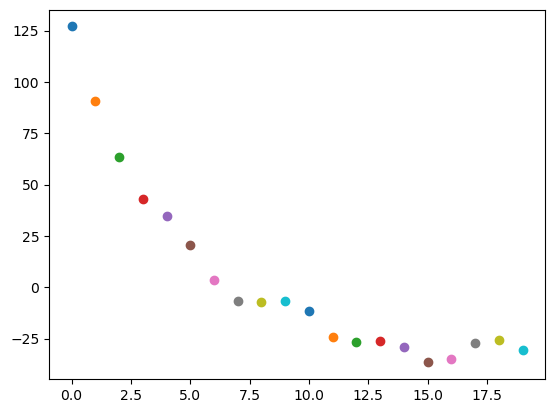

In [112]:
year           = 0
month          = 1
initialization = 2
for lag in range(20):
    #print(np.abs(np.linalg.det(theta_record[lag,:,:])))
    plt.scatter(lag,np.log(np.abs(np.linalg.det(theta_record[year, month, initialization, lag,:,:]))))

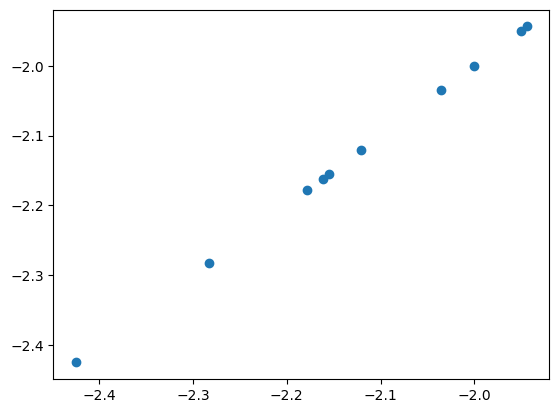

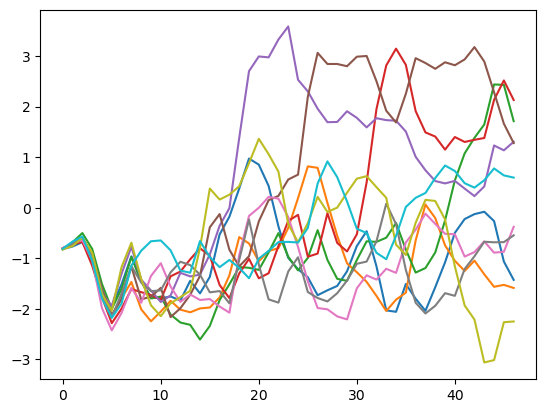

In [76]:
plt.scatter((APTM_time_series[:,i,j,k,1,:].dot(theta))[:,0],APTM_time_series[:,i,j,k,5,0])
# APTM_time_series.shape
plt.figure()
plt.plot(APTM_time_series[:,i,j,k,:,0].T)

In [ ]:
Jacobian = np.zeros((10,10,20,4,8,47)) # 10X10 is the Jacobian, 20 year, 4 months and 8 initializations, 47 lead time
for i,year in zip(np.arange(0,4),[0,1,10,11]):
    for j,initialization in  zip(np.arange(0,8),np.arange(0,8)):
        theta = np.linalg.inv(APTM_time_series[:,i,j,0,:].T.dot( APTM_time_series[:,i,j,0,:])).dot(APTM_time_series[:,i,j,0,:].T.dot*APTM_time_series[:,i,j,5,:]))  